## Imports

In [8]:
%matplotlib inline
import os
import os.path as op
import json
import errno
import random
import warnings
import joblib
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics.pairwise import pairwise_distances
import pretty_midi
from pypianoroll import Multitrack, Track

## Paths

In [34]:
repo_root = '/home/bgenchel/PlanNet/AIComposer'
boundaries_dir = op.join(repo_root, 'data', 'interim', 'lpd_synthesized_msaf_segmentation')
npz_dir = '/home/herman/lpd/lpd/lpd_cleansed'
id_path = '/home/herman/lpd/cleansed_ids.txt'

In [35]:
with open(id_path) as f:
    id_md5 = {line.split()[1]: line.split()[0] for line in f}
    
synth_id_md5 = {k:v for k,v in id_md5.items() if "TRA" in k}

## Path Utils

In [60]:
def make_sure_path_exists(path):
    """Create intermidate directories if the path does not exist."""
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

def moving_average(data, window, mode='valid'):
    """Return the moving averages of the data."""
    weights = np.repeat(1.0, window) / window
    return np.convolve(data, weights, mode)

def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return op.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def get_npz_path(msd_id):
    """Given an MSD ID, return the path to the corresponding npz file."""
    return op.join(npz_dir, msd_id_to_dirs(msd_id), synth_id_md5[msd_id] + '.npz')

def get_boundaries_path(msd_id):
    """Given an MSD ID, return the path to the corresponding npz file."""
    return op.join(boundaries_dir, msd_id_to_dirs(msd_id), synth_id_md5[msd_id] + '.json')

def get_boundaries(msd_id):
    return json.load(open(get_boundaries_path(msd_id), 'r'))

def get_multitrack(msd_id):
    """Given an MSD ID, return the loaded multi-track piano-roll."""
    return Multitrack(get_npz_path(msd_id))

## Viz Utils

In [79]:
COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def visualization(fn):
    """Decorator for visualization functions."""
    def decorated(*args, **kwargs):
        returns = fn(*args, **kwargs)
        if 'size' not in kwargs:
            kwargs['size'] = (10, 3)
        returns[0].set_size_inches(kwargs['size'][0], kwargs['size'][1])
        if 'filename' in kwargs:
            if 'dpi' not in kwargs:
                kwargs['dpi'] = 1200
            if '.' in kwargs['filename']:
                filepath = os.path.join(config['result_dir'],
                                        "{}.{}".format(kwargs['filename'],
                                                       config['extension']))
            else:
                filepath = os.path.join(config['result_dir'],
                                        kwargs['filename'])
            plt.savefig(filepath, dpi=kwargs['dpi'], bbox_inches='tight')
        return returns
    return decorated

def visualize_multitrack(m):
    """Visualize a multi-track piano-roll."""
    bar_resolution = 4 * m.beat_resolution
    fig, axs = m.plot(preset='frame', grid='x')
    plt.minorticks_off()
    num_bar = m.tracks[0].pianoroll.shape[0] // bar_resolution
    xticks_major = bar_resolution * np.arange(0, num_bar)
    for ax in axs:
        ax.set_xticks(xticks_major)
    return fig, axs

@visualization
def visualize(m, **kwargs):
    """Visualize a multi-track piano-roll. See `visualize_multitrack()` for the
    documentation."""
    return visualize_multitrack(m, **kwargs)

@visualization
def visualize_with_boundaries(msd_id, resolution=96, tolerance=0,
                                         return_boundaries=False, **kwargs):
    """Visualize a multi-track piano-roll with activation boundaries."""
    m = get_multitrack(msd_id)
    m.pad_to_multiple(resolution)
    fig, axs = visualize_multitrack(m)
    boundaries = get_boundaries(msd_id)
    
    color_idx = 0
    color_dict = {}
    for idx in range(len(boundaries[:-1])):
        label, position = boundaries[idx]['label'], boundaries[idx]['ticks']
        if label not in color_dict:
            color_dict[label] = COLORS[color_idx]
            color_idx += 1
        for ax in axs:
            position = boundaries[idx]['ticks']
            width = (boundaries[idx+1]['ticks'] - position)
            ax.add_patch(
                matplotlib.patches.Rectangle(
                    (position, 0), width, 128, facecolor=color_dict[label], alpha=0.1))
            ax.add_patch(
                matplotlib.patches.Rectangle(
                    (position, 0), width, 129, facecolor='none', edgecolor='black',
                    linestyle='-', linewidth=3))
    fig.set_size_inches(100, 12)
    if return_boundaries:
        return fig, axs, boundaries
    return fig, axs


## Pick and Visualize Songs

['A', 'B', 'C', 'C', 'D', 'E', 'C', 'C', 'A']


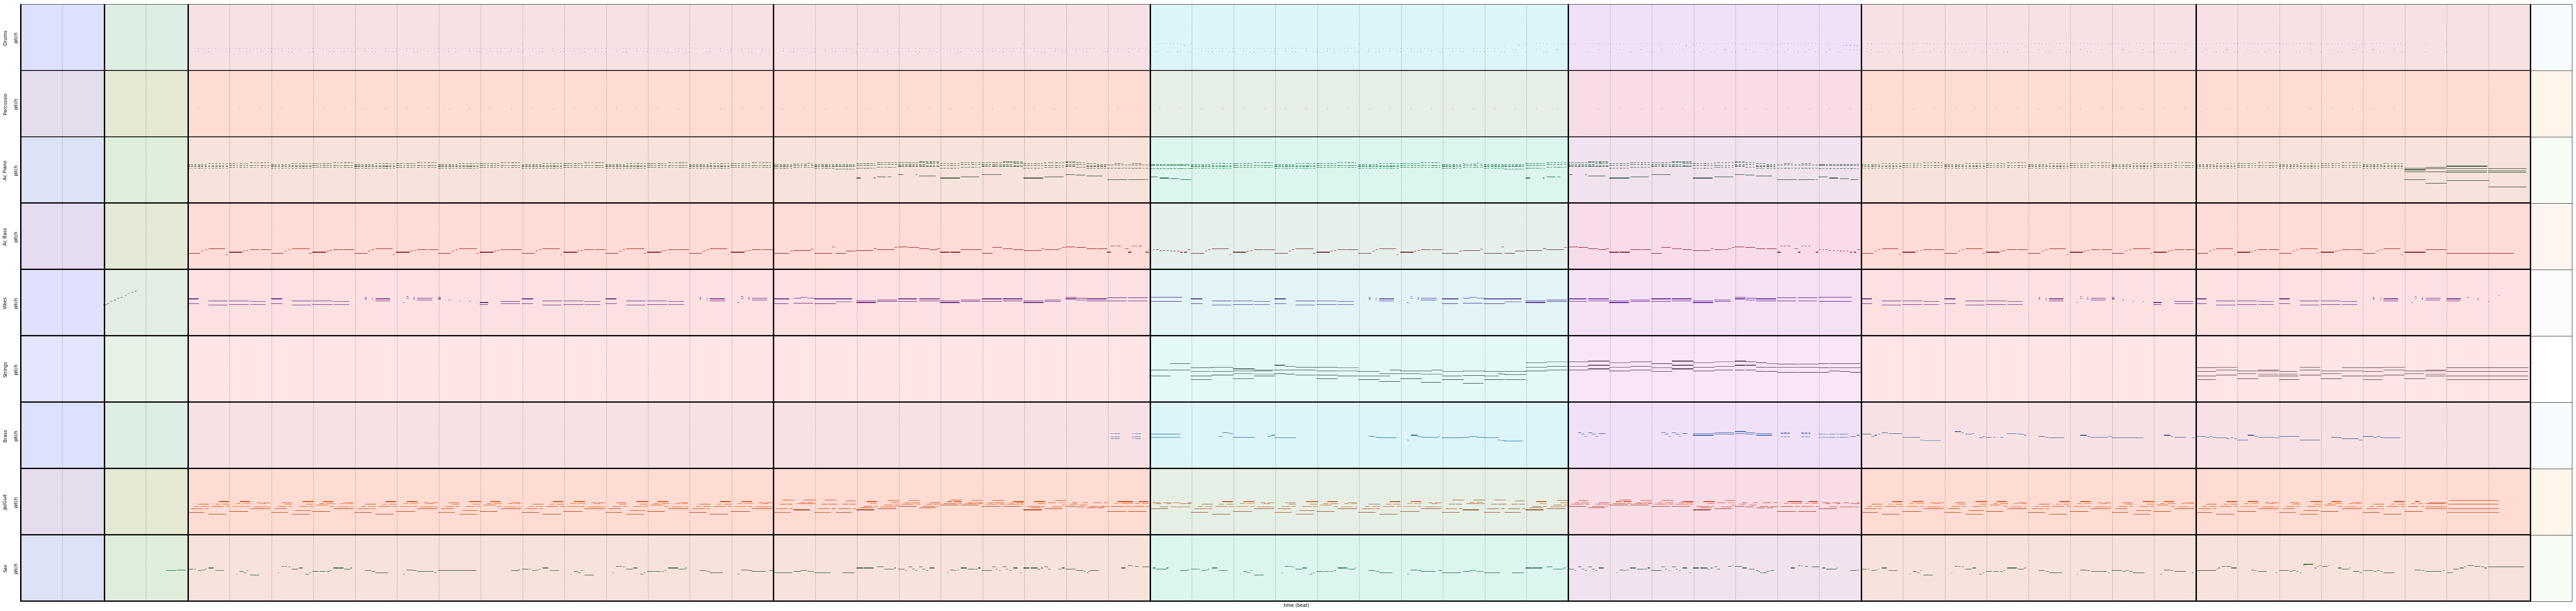

In [89]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))

['A', 'B', 'C', 'D', 'C', 'B', 'E', 'B', 'A']


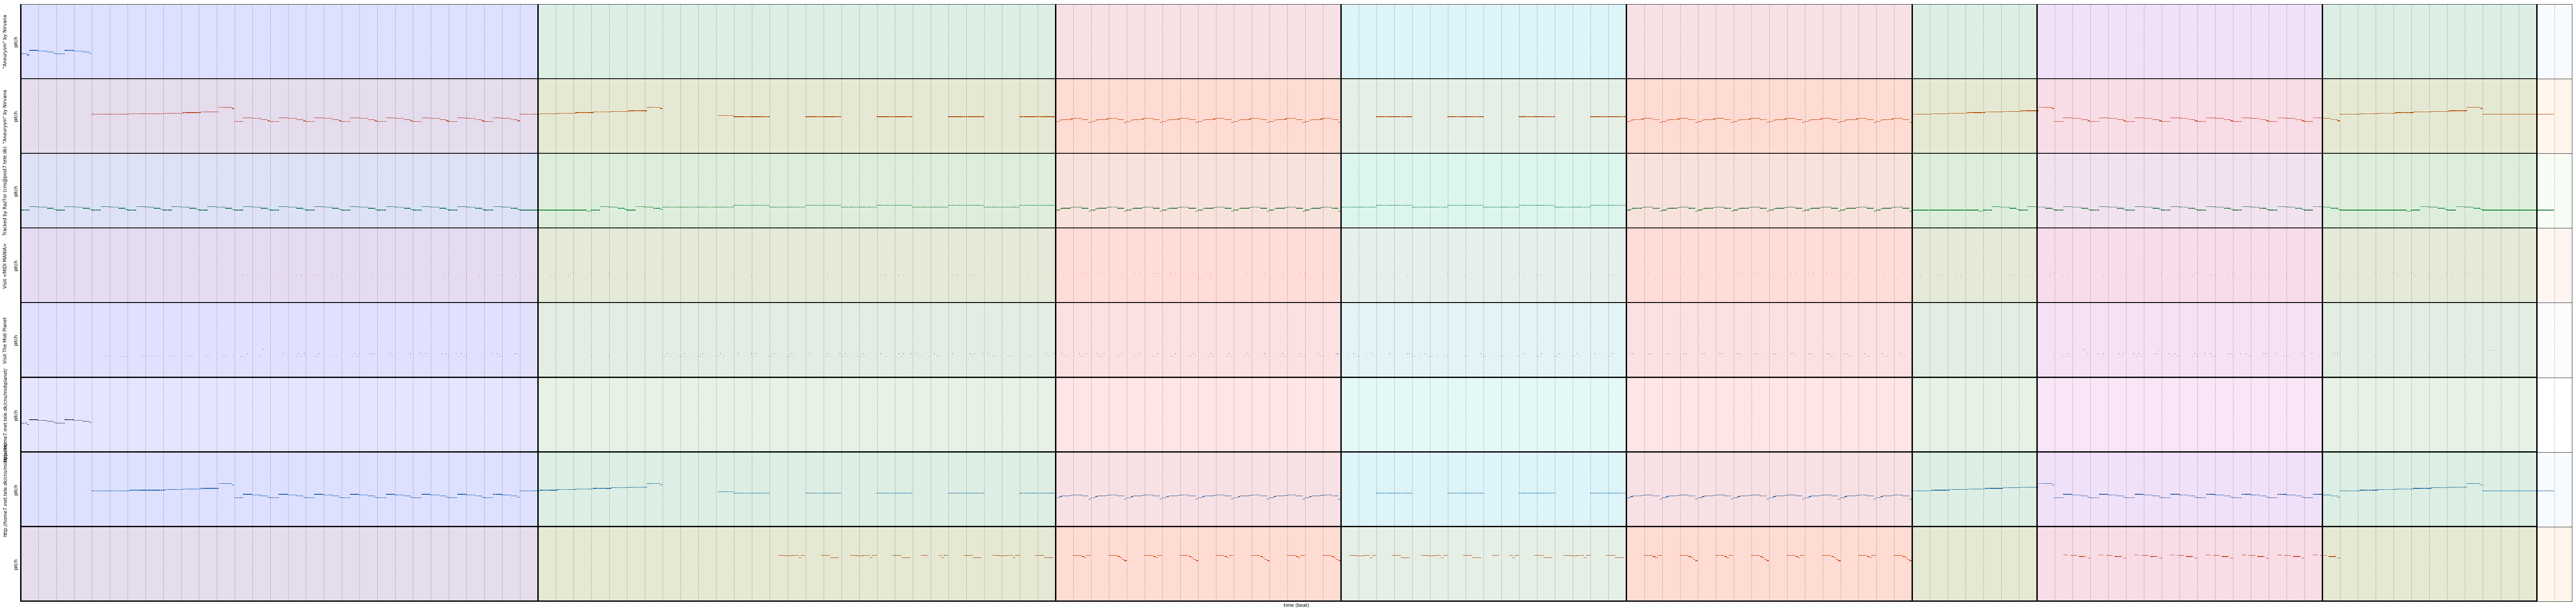

In [81]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))

['A', 'B', 'C', 'C', 'D', 'C', 'C', 'D', 'C', 'D', 'D', 'E', 'E', 'A']


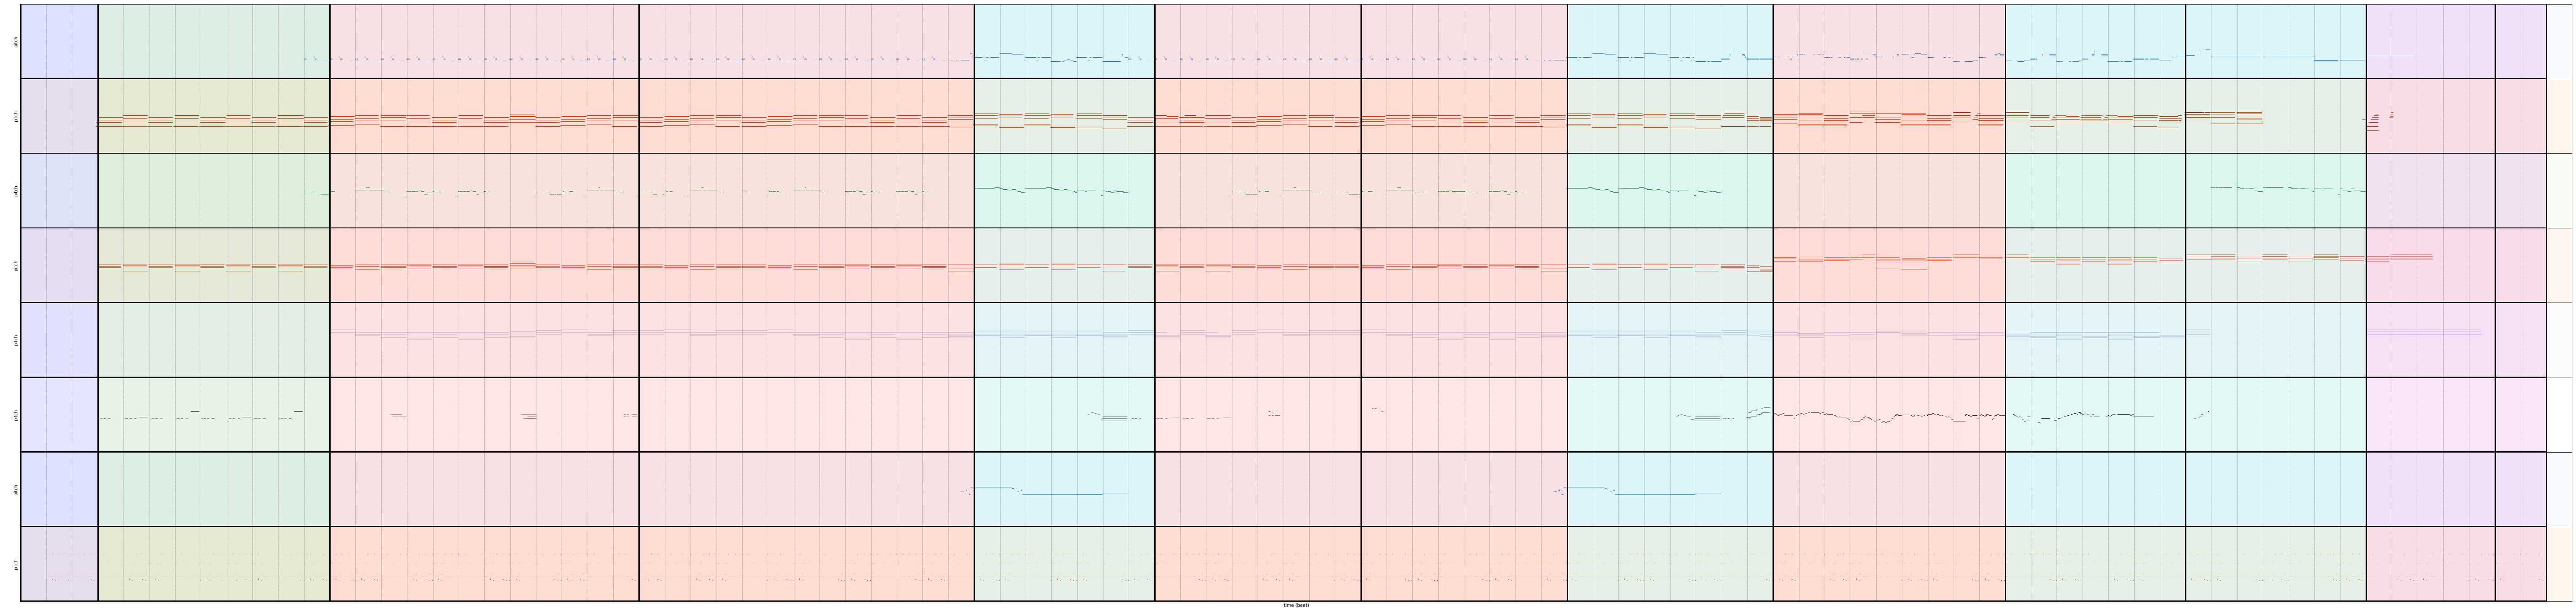

In [82]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))

['A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A']


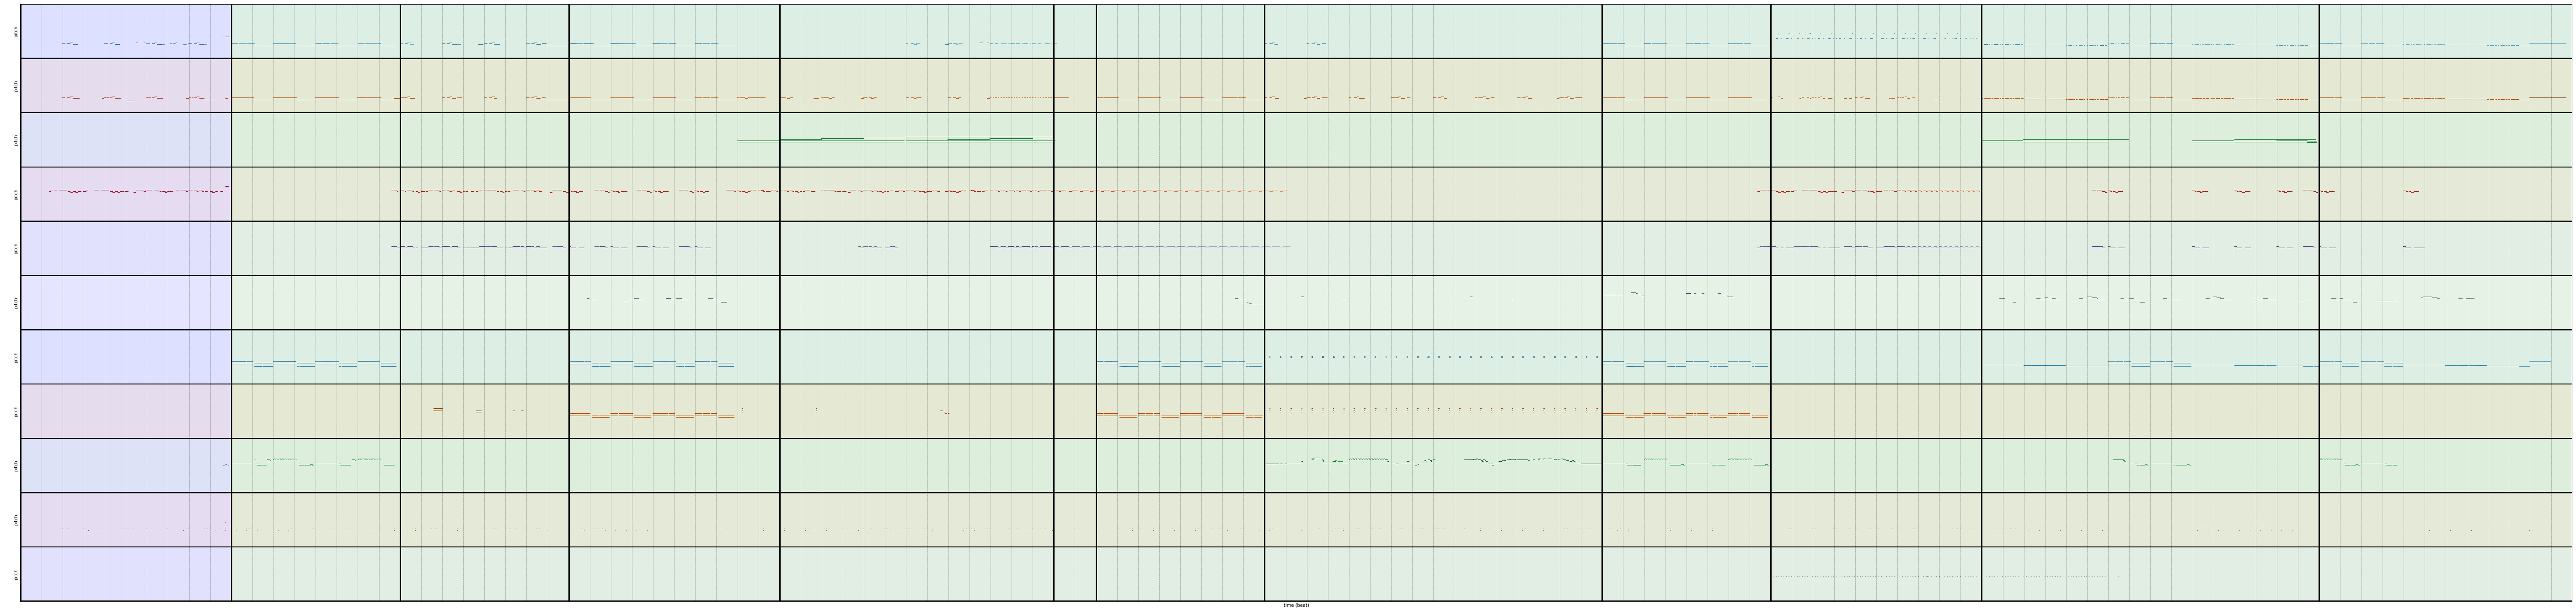

In [83]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))

['A', 'B', 'C', 'C', 'C', 'D', 'D', 'D', 'C', 'A']


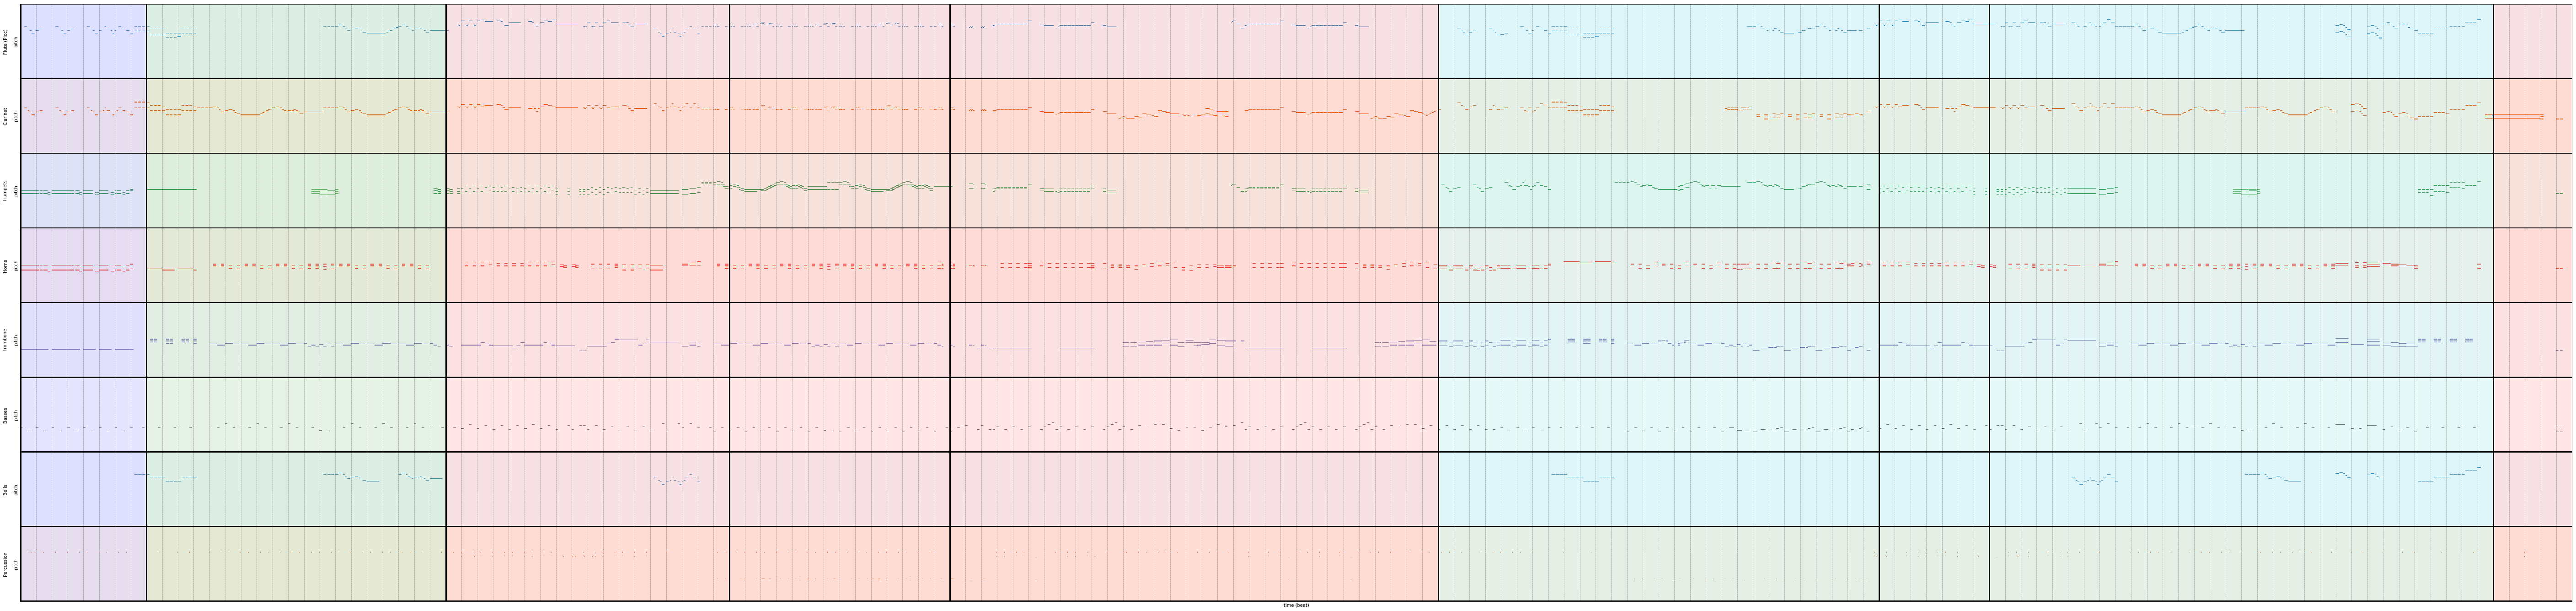

In [88]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))

['A', 'B', 'B', 'B', 'B', 'C', 'B', 'D', 'D', 'A']


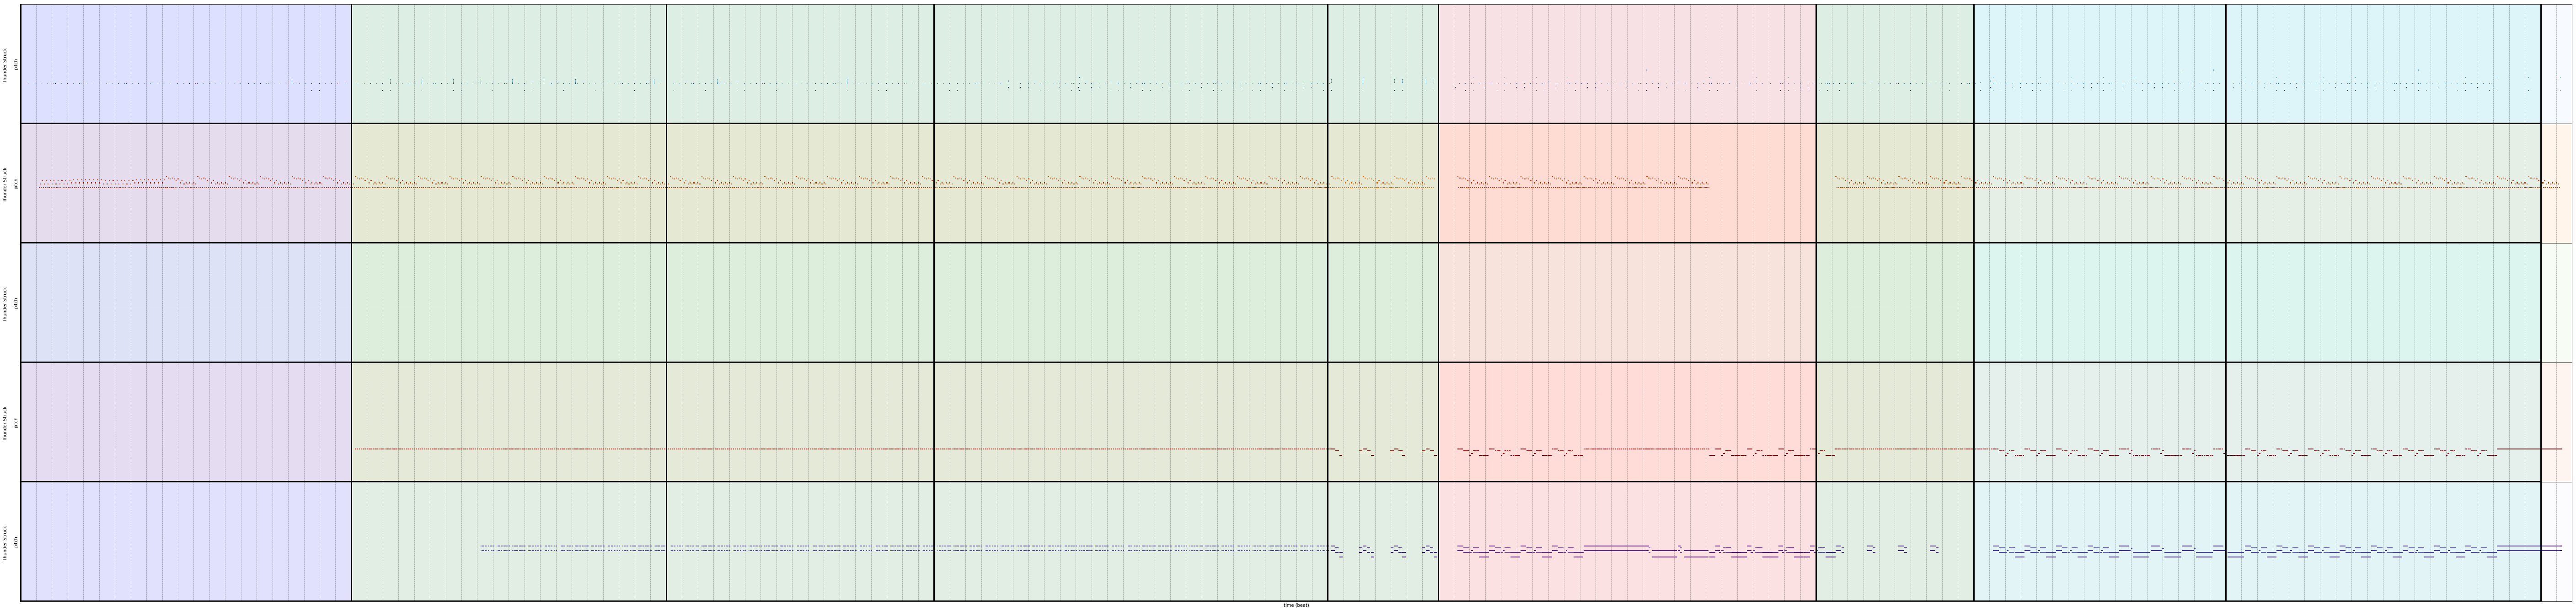

In [87]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))

['A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'C', 'D', 'D', 'D', 'B', 'B', 'B', 'B', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'A']


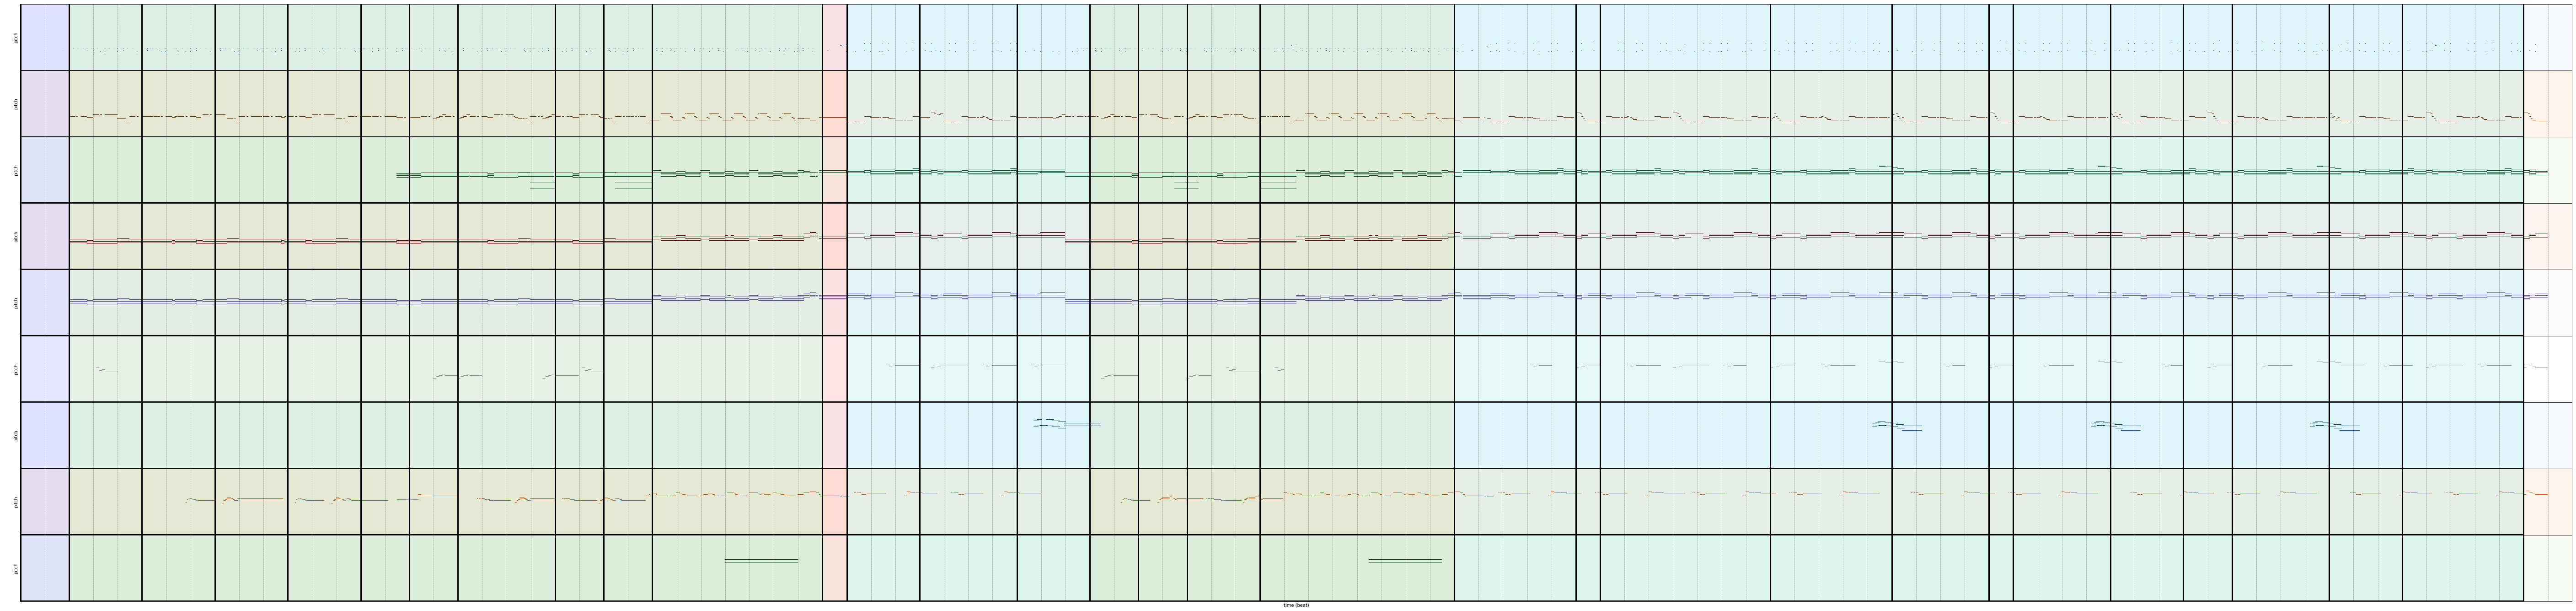

In [86]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))

['A', 'B', 'B', 'C', 'B', 'D', 'C', 'B', 'B', 'B', 'A']


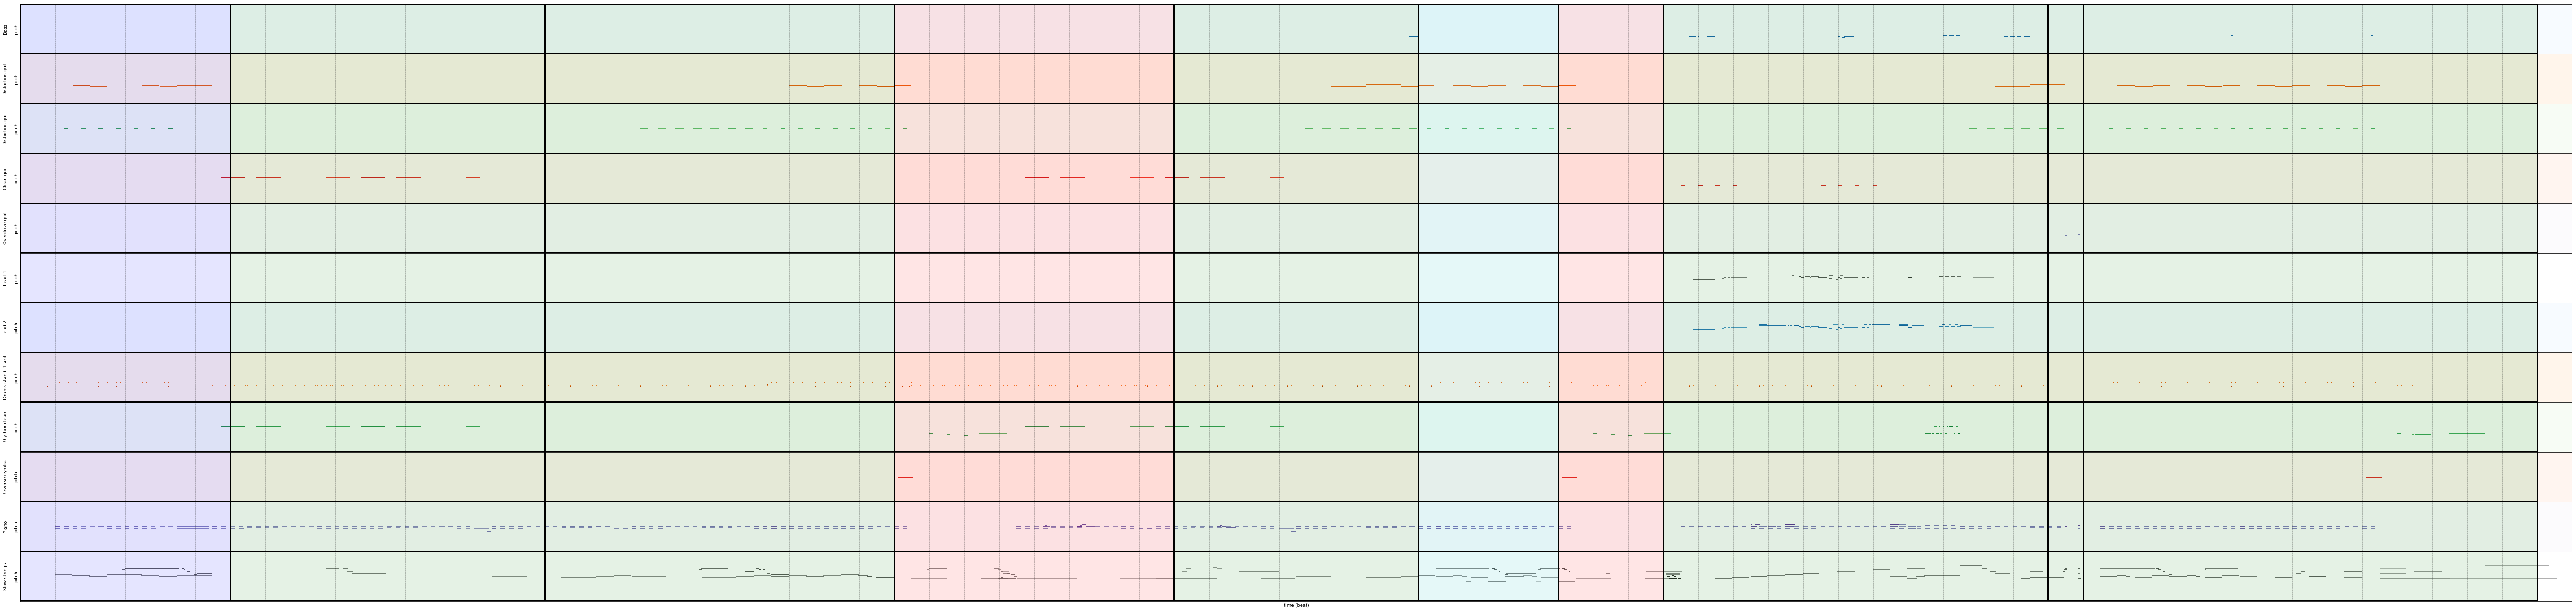

In [85]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))

['A', 'B', 'C', 'C', 'C', 'D', 'B', 'E', 'D', 'D', 'D', 'D', 'A']


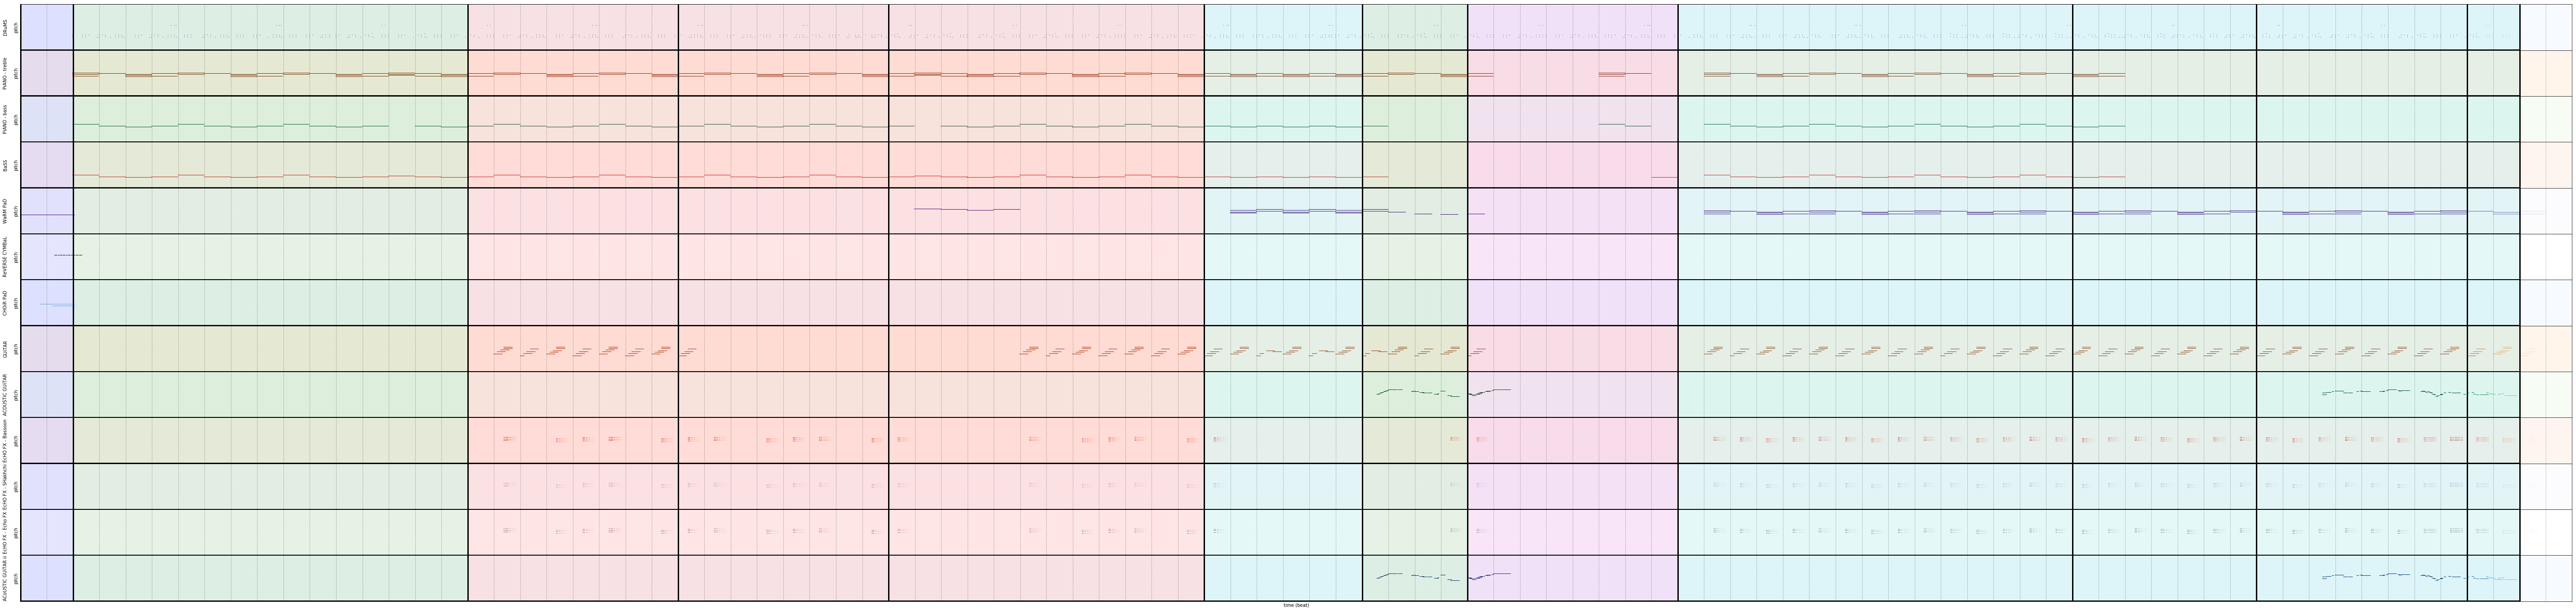

In [84]:
msd_id = random.choice(list(synth_id_md5.keys()))
print([b['label'] for b in get_boundaries(msd_id)])
axes_array = visualize_with_boundaries(msd_id, size=(100, 24))